In [47]:
import pandas as pd
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
from PIL import Image
import cv2
import glob
import os
import pickle
import xml.etree.ElementTree as ET
from os import listdir, getcwd
from os.path import join
import struct
from tqdm import tqdm
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import sys
import os
import glob
import shutil
from tensorflow.keras.models import Sequential,load_model, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, BatchNormalization, GlobalAveragePooling2D, UpSampling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import cv2
import tensorflow
from google.colab.patches import cv2_imshow
from PIL import Image
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from IPython.display import Image
from keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import Input, Concatenate, UpSampling2D

In [48]:
list_ds = tf.data.Dataset.list_files('/content/drive/MyDrive/Medbikri/Dataset/images/*.jpeg')

In [49]:
h, w = 512, 512

def normalize(input_image):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  return input_image


def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img)
  # resize the image to the desired size
  return tf.image.resize(img, [h, w])

def decode_mask_img(img):
  # convert the compressed string to a 2D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=1)
  # resize the image to the desired size
  return tf.image.resize(img, [h, w])


def process_path(file_path):
  # mask_file_path = tf.strings.regex_replace(file_path, '.jpg', '.jpeg')

  table_mask_file_path = tf.strings.regex_replace(file_path, 'images', 'table mask')
  print(table_mask_file_path)
  img = normalize(decode_img(tf.io.read_file(file_path)))
  table_mask = normalize(decode_mask_img(tf.io.read_file(table_mask_file_path)))

  return img, {"table_output" : table_mask }

In [50]:
DATASET_SIZE = len(list(list_ds))
train_size = int(0.9 * DATASET_SIZE)
test_size = int(0.1 * DATASET_SIZE)

train = list_ds.take(train_size)
test = list_ds.skip(train_size)
# train = list_ds.take(100)
# test = list_ds.skip(10)

TRAIN_LENGTH = len(list(train))
BATCH_SIZE = 2
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = 5

train = train.shuffle(BUFFER_SIZE)

train = train.map(process_path,
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)

test = test.map(process_path)

train_dataset = train.batch(BATCH_SIZE).repeat().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

Tensor("StaticRegexReplace:0", shape=(), dtype=string)
Tensor("StaticRegexReplace:0", shape=(), dtype=string)


In [51]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'Table Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

(512, 512, 3)


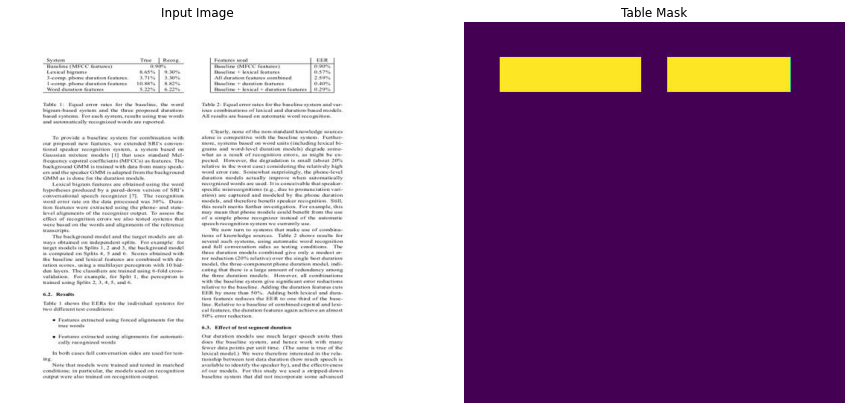

(512, 512, 3)


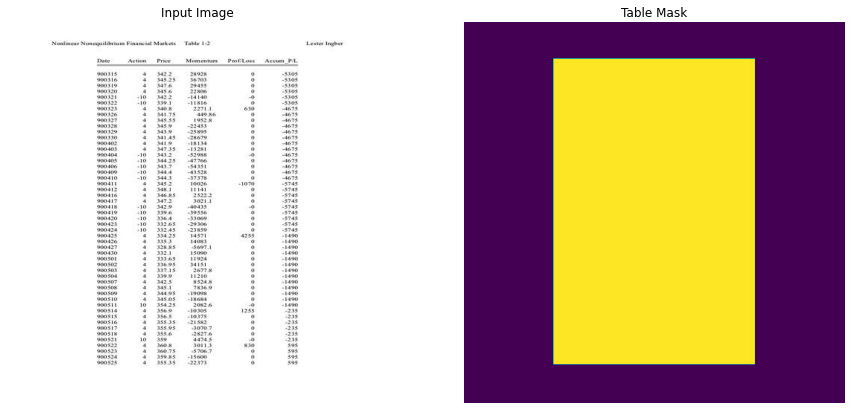

In [52]:
for image, mask  in train.take(2):
  print(image.shape)
  # print(mask.shape)
  display([image, mask['table_output']])

In [53]:
class TableNet:
  @staticmethod
  def vgg_base(inputs):
    base_model = VGG19(
        input_shape=[512, 512, 3],
        include_top=False, weights='imagenet')
    
    layer_names = ['block3_pool', 'block4_pool', 'block5_pool']
    layers = [base_model.get_layer(name).output for name in layer_names]

    pool_layers_model = Model(inputs=base_model.input, outputs=layers, name='VGG-19')
    pool_layers_model.trainable = False

    return pool_layers_model(inputs)

  @staticmethod
  def build_table_decoder(inputs, pool3, pool4):
    x = Conv2D(512, (1, 1), activation = 'relu', name='conv7_table')(inputs)
    x = UpSampling2D(size=(2, 2))(x)

    concatenated = Concatenate()([x, pool4])

    x = UpSampling2D(size=(2,2))(concatenated)
    
    concatenated = Concatenate()([x, pool3])

    x = UpSampling2D(size=(2,2))(concatenated)
    x = UpSampling2D(size=(2,2))(x)

    last = tf.keras.layers.Conv2DTranspose(3, 3, strides=2,padding='same', name='table_output') 
    x = last(x)
    return x
  
  @staticmethod
  def build():
    inputShape = (512, 512, 3)

    inputs = Input(shape=inputShape, name='input')

    pool_layers = TableNet.vgg_base(inputs)

    x = Conv2D(512, (1, 1), activation = 'relu', name='block6_conv1')(pool_layers[-1])
    x = Dropout(0.8, name = 'block6_dropout1')(x)
    x = Conv2D(512, (1, 1), activation = 'relu', name='block6_conv2')(x)
    x = Dropout(0.8, name = 'block6_dropout2')(x)
    
    table_mask = TableNet.build_table_decoder(x, pool_layers[0], pool_layers[1])

    model = Model(			
              inputs=inputs,
			        outputs=table_mask,
			        name="TableNet")
    
    return model

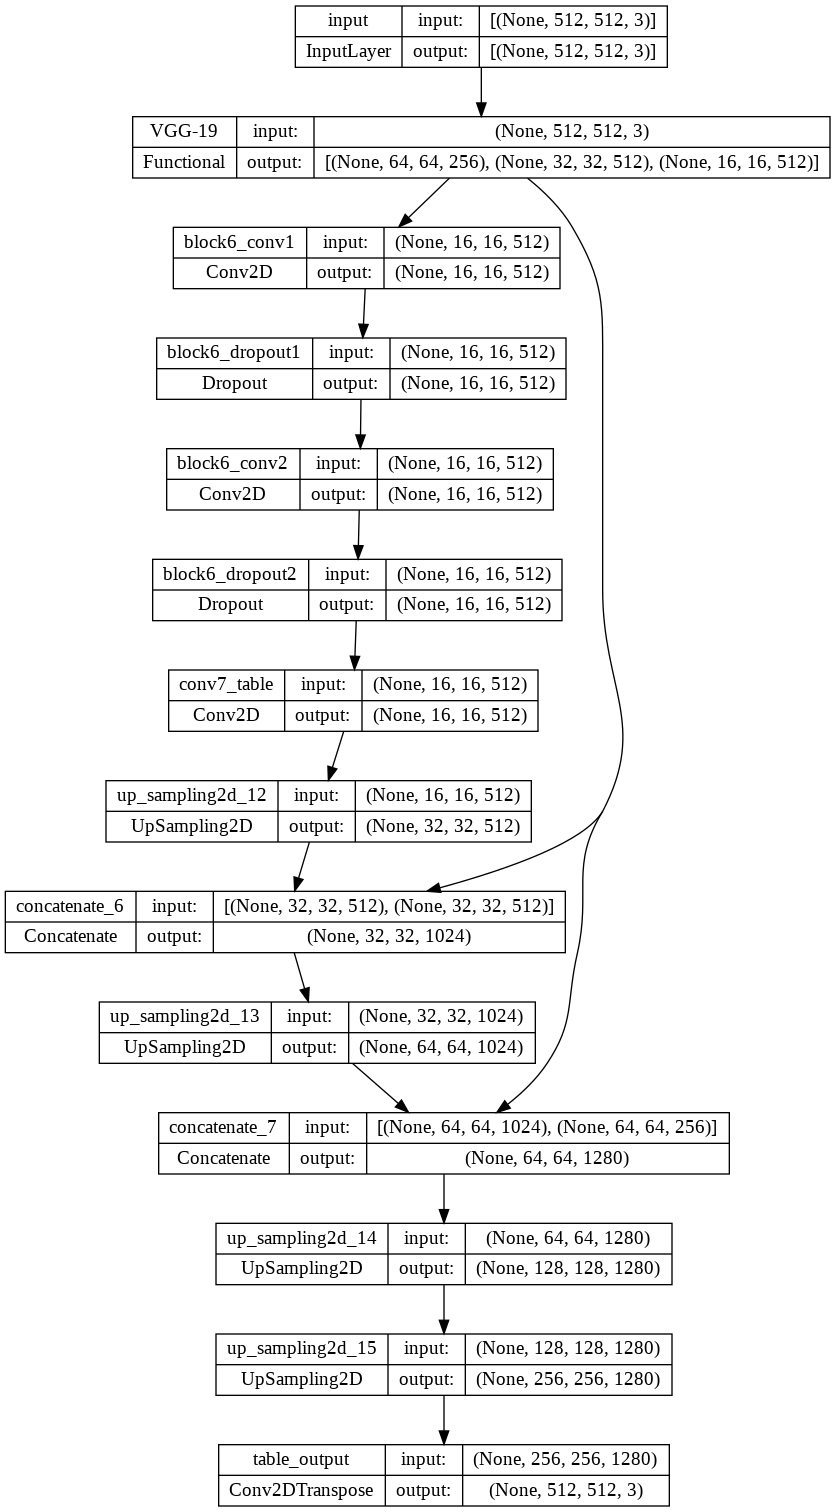

In [54]:
model = TableNet.build()
tf.keras.utils.plot_model(model, show_shapes=True)

In [55]:
losses = {
	"table_output": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
}

lossWeights = {"table_output": 1.0}

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, epsilon=1e-08),
              loss=losses,
              metrics=['accuracy'],
              loss_weights=lossWeights)


In [56]:
def create_mask(pred_mask1):
  pred_mask1 = tf.argmax(pred_mask1, axis=-1)
  pred_mask1 = pred_mask1[..., tf.newaxis]
  return pred_mask1[0]


In [57]:
for image, mask in train_dataset.take(1):
  sample_image, sample_mask1 = image, mask['table_output']

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, (mask1) in dataset.take(num):
      pred_mask1= model.predict(image, verbose=1)
      table_mask= create_mask(pred_mask1)
      
      display([image[0], table_mask])
  else:
    pred_mask1 = model.predict(sample_image, verbose=1)
    table_mask= create_mask(pred_mask1)

    display([sample_image[0], table_mask])

In [58]:
# show_predictions()

In [59]:
from IPython.display import clear_output

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath="mymodel_{epoch}",
        save_best_only=True,
        monitor="val_loss",
        verbose=1,
    )

early_stoping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        verbose=1,
    )

In [60]:
EPOCHS = 125
VAL_SUBSPLITS = 5
VALIDATION_STEPS = test_size//BATCH_SIZE//VAL_SUBSPLITS


model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[model_checkpoint])

Epoch 1/1000
5/5 [==============================] - ETA: 0s - loss: 4.2296 - accuracy: 0.3469
Epoch 1: val_loss improved from inf to 2.10790, saving model to mymodel_1


5/5 [==============================] - 128s 29s/step - loss: 4.2296 - accuracy: 0.3469 - val_loss: 2.1079 - val_accuracy: 0.5257
Epoch 2/1000
5/5 [==============================] - ETA: 0s - loss: 1.2048 - accuracy: 0.7189
Epoch 2: val_loss improved from 2.10790 to 1.31083, saving model to mymodel_2


5/5 [==============================] - 124s 29s/step - loss: 1.2048 - accuracy: 0.7189 - val_loss: 1.3108 - val_accuracy: 0.8242
Epoch 3/1000
5/5 [==============================] - ETA: 0s - loss: 0.6921 - accuracy: 0.9179
Epoch 3: val_loss improved from 1.31083 to 1.00536, saving model to mymodel_3


5/5 [==============================] - 124s 29s/step - loss: 0.6921 - accuracy: 0.9179 - val_loss: 1.0054 - val_accuracy: 0.9007
Epoch 4/1000
5/5 [==============================] - ETA: 0s - loss: 1.0419 - accuracy: 0.9058
Epoch 4: val_loss improved from 1.00536 to 0.39842, saving model to mymodel_4


5/5 [==============================] - 128s 29s/step - loss: 1.0419 - accuracy: 0.9058 - val_loss: 0.3984 - val_accuracy: 0.9490
Epoch 5/1000
5/5 [==============================] - ETA: 0s - loss: 0.3116 - accuracy: 0.9592
Epoch 5: val_loss improved from 0.39842 to 0.35195, saving model to mymodel_5


5/5 [==============================] - 121s 28s/step - loss: 0.3116 - accuracy: 0.9592 - val_loss: 0.3519 - val_accuracy: 0.9462
Epoch 6/1000
5/5 [==============================] - ETA: 0s - loss: 0.8953 - accuracy: 0.8845
Epoch 6: val_loss did not improve from 0.35195
5/5 [==============================] - 115s 27s/step - loss: 0.8953 - accuracy: 0.8845 - val_loss: 0.6548 - val_accuracy: 0.8954
Epoch 7/1000
5/5 [==============================] - ETA: 0s - loss: 0.7785 - accuracy: 0.8813
Epoch 7: val_loss did not improve from 0.35195
5/5 [==============================] - 117s 27s/step - loss: 0.7785 - accuracy: 0.8813 - val_loss: 0.9672 - val_accuracy: 0.8145
Epoch 8/1000
5/5 [==============================] - ETA: 0s - loss: 0.9324 - accuracy: 0.7963
Epoch 8: val_loss did not improve from 0.35195
5/5 [==============================] - 116s 27s/step - loss: 0.9324 - accuracy: 0.7963 - val_loss: 0.6822 - val_accuracy: 0.7978
Epoch 9/1000
5/5 [==============================] - ETA: 0s -

5/5 [==============================] - 122s 28s/step - loss: 0.2599 - accuracy: 0.9297 - val_loss: 0.2371 - val_accuracy: 0.9299
Epoch 16/1000
5/5 [==============================] - ETA: 0s - loss: 0.3638 - accuracy: 0.9208 
Epoch 16: val_loss did not improve from 0.23706
5/5 [==============================] - 122s 28s/step - loss: 0.3638 - accuracy: 0.9208 - val_loss: 0.5673 - val_accuracy: 0.8590
Epoch 17/1000
5/5 [==============================] - ETA: 0s - loss: 0.1477 - accuracy: 0.9666
Epoch 17: val_loss did not improve from 0.23706
5/5 [==============================] - 119s 27s/step - loss: 0.1477 - accuracy: 0.9666 - val_loss: 0.3378 - val_accuracy: 0.9088
Epoch 18/1000
5/5 [==============================] - ETA: 0s - loss: 0.3293 - accuracy: 0.9088
Epoch 18: val_loss did not improve from 0.23706
5/5 [==============================] - 117s 27s/step - loss: 0.3293 - accuracy: 0.9088 - val_loss: 0.3806 - val_accuracy: 0.9018
Epoch 19/1000
5/5 [==============================] - E

5/5 [==============================] - 122s 28s/step - loss: 0.3202 - accuracy: 0.9064 - val_loss: 0.2328 - val_accuracy: 0.9249
Epoch 20/1000
5/5 [==============================] - ETA: 0s - loss: 0.1471 - accuracy: 0.9485
Epoch 20: val_loss did not improve from 0.23275
5/5 [==============================] - 117s 27s/step - loss: 0.1471 - accuracy: 0.9485 - val_loss: 0.3398 - val_accuracy: 0.9005
Epoch 21/1000
5/5 [==============================] - ETA: 0s - loss: 0.3188 - accuracy: 0.9108
Epoch 21: val_loss did not improve from 0.23275
5/5 [==============================] - 119s 27s/step - loss: 0.3188 - accuracy: 0.9108 - val_loss: 0.3002 - val_accuracy: 0.9087
Epoch 22/1000
5/5 [==============================] - ETA: 0s - loss: 0.3119 - accuracy: 0.9141
Epoch 22: val_loss did not improve from 0.23275
5/5 [==============================] - 117s 27s/step - loss: 0.3119 - accuracy: 0.9141 - val_loss: 0.4142 - val_accuracy: 0.8766
Epoch 23/1000
5/5 [==============================] - ET

5/5 [==============================] - 131s 30s/step - loss: 0.3098 - accuracy: 0.9077 - val_loss: 0.1404 - val_accuracy: 0.9611
Epoch 28/1000
5/5 [==============================] - ETA: 0s - loss: 0.3481 - accuracy: 0.9162 
Epoch 28: val_loss did not improve from 0.14039
5/5 [==============================] - 122s 28s/step - loss: 0.3481 - accuracy: 0.9162 - val_loss: 0.1962 - val_accuracy: 0.9374
Epoch 29/1000
5/5 [==============================] - ETA: 0s - loss: 0.2978 - accuracy: 0.9005
Epoch 29: val_loss did not improve from 0.14039
5/5 [==============================] - 120s 28s/step - loss: 0.2978 - accuracy: 0.9005 - val_loss: 0.2441 - val_accuracy: 0.9181
Epoch 30/1000
5/5 [==============================] - ETA: 0s - loss: 0.2888 - accuracy: 0.9059
Epoch 30: val_loss did not improve from 0.14039
5/5 [==============================] - 118s 27s/step - loss: 0.2888 - accuracy: 0.9059 - val_loss: 0.2105 - val_accuracy: 0.9304
Epoch 31/1000
5/5 [==============================] - E

5/5 [==============================] - 127s 29s/step - loss: 0.1516 - accuracy: 0.9521 - val_loss: 0.1213 - val_accuracy: 0.9600
Epoch 48/1000
5/5 [==============================] - ETA: 0s - loss: 0.2571 - accuracy: 0.9142
Epoch 48: val_loss did not improve from 0.12126
5/5 [==============================] - 122s 28s/step - loss: 0.2571 - accuracy: 0.9142 - val_loss: 0.2863 - val_accuracy: 0.8956
Epoch 49/1000
5/5 [==============================] - ETA: 0s - loss: 0.2416 - accuracy: 0.9128
Epoch 49: val_loss did not improve from 0.12126
5/5 [==============================] - 119s 27s/step - loss: 0.2416 - accuracy: 0.9128 - val_loss: 0.1999 - val_accuracy: 0.9360
Epoch 50/1000
5/5 [==============================] - ETA: 0s - loss: 0.2592 - accuracy: 0.9162
Epoch 50: val_loss did not improve from 0.12126
5/5 [==============================] - 120s 28s/step - loss: 0.2592 - accuracy: 0.9162 - val_loss: 0.3368 - val_accuracy: 0.8884
Epoch 51/1000
5/5 [==============================] - ET

5/5 [==============================] - 125s 29s/step - loss: 0.2940 - accuracy: 0.9035 - val_loss: 0.1166 - val_accuracy: 0.9615
Epoch 69/1000
5/5 [==============================] - ETA: 0s - loss: 0.1444 - accuracy: 0.9477 
Epoch 69: val_loss did not improve from 0.11656
5/5 [==============================] - 123s 28s/step - loss: 0.1444 - accuracy: 0.9477 - val_loss: 0.3661 - val_accuracy: 0.8636
Epoch 70/1000
5/5 [==============================] - ETA: 0s - loss: 0.2229 - accuracy: 0.9257
Epoch 70: val_loss did not improve from 0.11656
5/5 [==============================] - 117s 27s/step - loss: 0.2229 - accuracy: 0.9257 - val_loss: 0.2808 - val_accuracy: 0.9102
Epoch 71/1000
5/5 [==============================] - ETA: 0s - loss: 0.1559 - accuracy: 0.9430
Epoch 71: val_loss did not improve from 0.11656
5/5 [==============================] - 117s 27s/step - loss: 0.1559 - accuracy: 0.9430 - val_loss: 0.2432 - val_accuracy: 0.9189
Epoch 72/1000
5/5 [==============================] - E

5/5 [==============================] - 123s 29s/step - loss: 0.1962 - accuracy: 0.9251 - val_loss: 0.1107 - val_accuracy: 0.9662
Epoch 76/1000
5/5 [==============================] - ETA: 0s - loss: 0.2373 - accuracy: 0.9139
Epoch 76: val_loss did not improve from 0.11066
5/5 [==============================] - 117s 27s/step - loss: 0.2373 - accuracy: 0.9139 - val_loss: 0.2340 - val_accuracy: 0.9062
Epoch 77/1000
5/5 [==============================] - ETA: 0s - loss: 0.1616 - accuracy: 0.9480
Epoch 77: val_loss did not improve from 0.11066
5/5 [==============================] - 116s 27s/step - loss: 0.1616 - accuracy: 0.9480 - val_loss: 0.1349 - val_accuracy: 0.9493
Epoch 78/1000
5/5 [==============================] - ETA: 0s - loss: 0.1747 - accuracy: 0.9395
Epoch 78: val_loss did not improve from 0.11066
5/5 [==============================] - 116s 27s/step - loss: 0.1747 - accuracy: 0.9395 - val_loss: 0.1736 - val_accuracy: 0.9368
Epoch 79/1000
5/5 [==============================] - ET

KeyboardInterrupt: ignored

1/1 [==============================] - 14s 14s/step


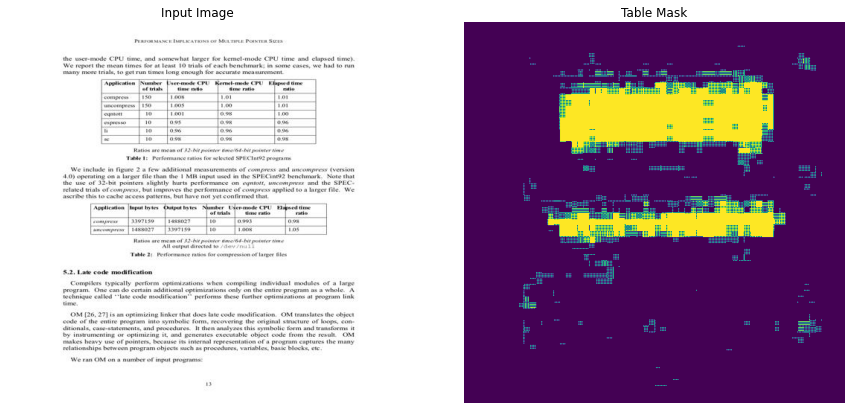

1/1 [==============================] - 11s 11s/step


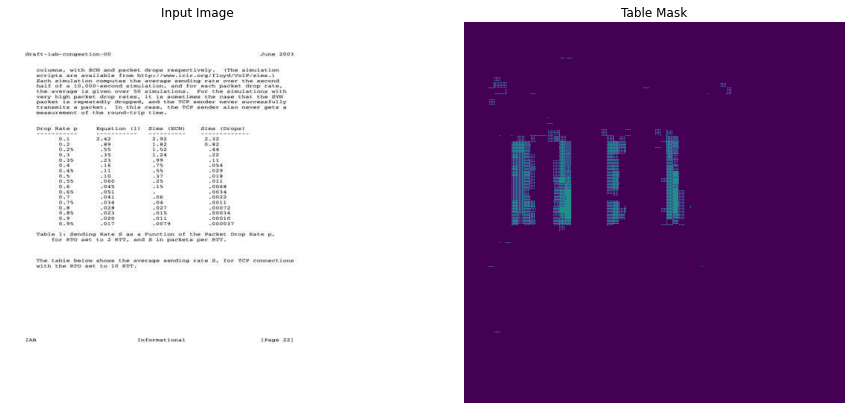

1/1 [==============================] - 8s 8s/step


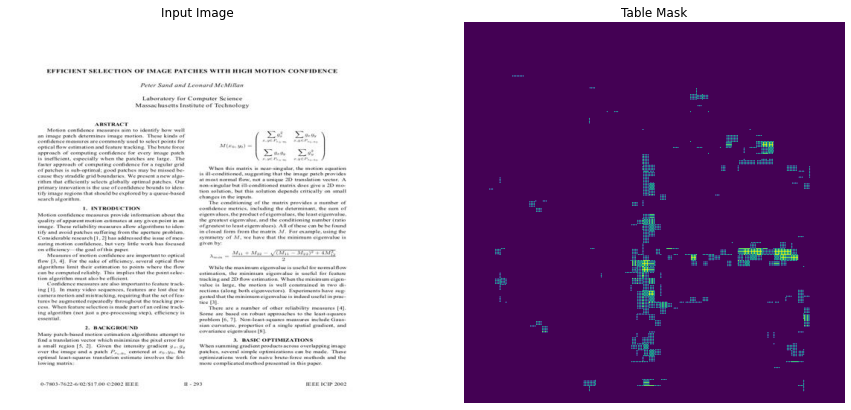

1/1 [==============================] - 8s 8s/step


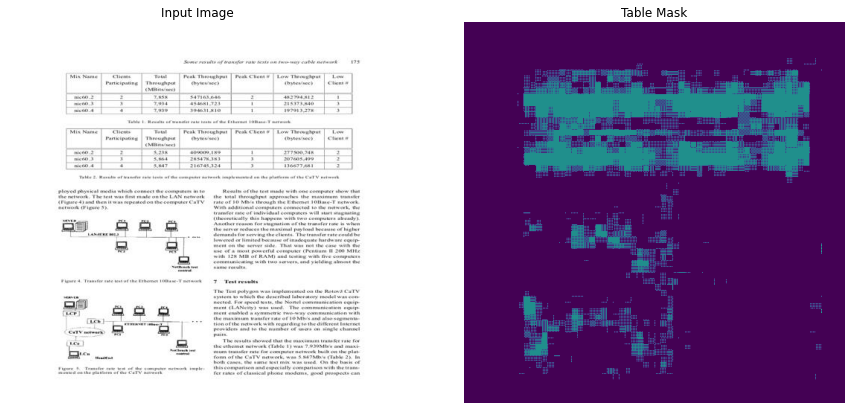

1/1 [==============================] - 8s 8s/step


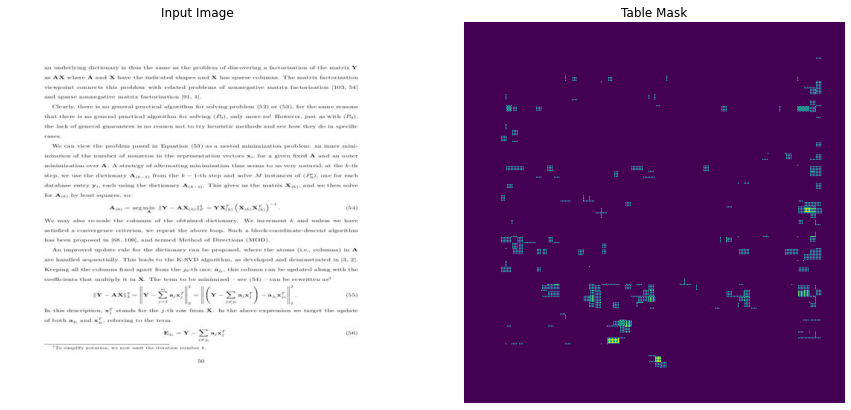

In [61]:
show_predictions(train_dataset, 5)

In [68]:
model.save('model2')

In [69]:
!zip -r model2.zip model2/

updating: model1/ (stored 0%)
updating: model1/variables/ (stored 0%)
updating: model1/variables/variables.index (deflated 69%)
updating: model1/variables/variables.data-00000-of-00001 (deflated 7%)
updating: model1/saved_model.pb (deflated 90%)
updating: model1/assets/ (stored 0%)
updating: model1/keras_metadata.pb (deflated 96%)


In [71]:
!cp model2.zip '/content/drive/My Drive/Medbikri/'